# Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import copy

# Importing the data.
## Adding a column for Months and filling it by months from 1 to 12.

In [2]:
df = pd.read_csv("Data.csv")
df = df.rename(columns={df.columns[0] : 'Date',df.columns[1] : 'Price'})
df['Months'] = df['Date']
for i in range(len(df["Months"])):
  df["Months"][i] = df["Months"][i].split('-')[1]
print(df)

         Date  Price Months
0    01-01-92   1744     01
1    01-02-92   1990     02
2    01-03-92   2177     03
3    01-04-92   2601     04
4    01-05-92   2171     05
..        ...    ...    ...
335  01-12-19   8669     12
336  01-01-20   8971     01
337  01-02-20  10567     02
338  01-03-20   9314     03
339  01-04-20   6395     04

[340 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Plotting the Date with Price values

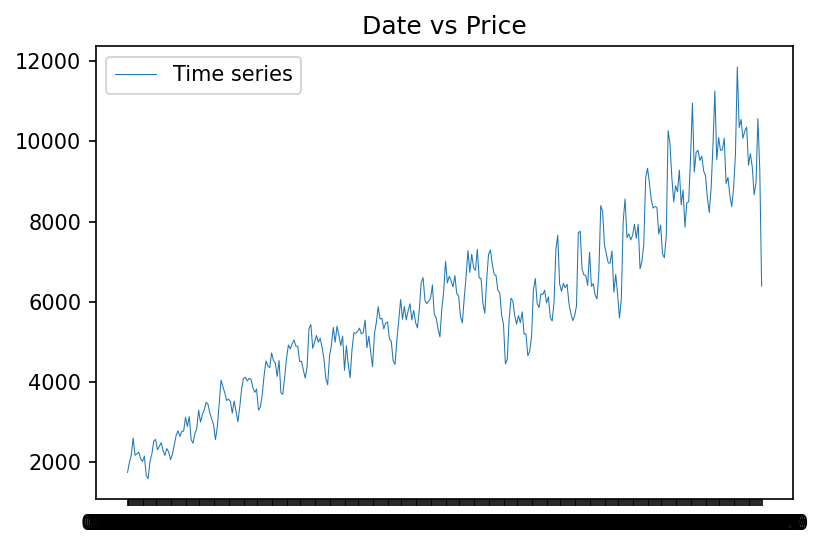

In [19]:
fig = plt.figure(dpi=150)
plt.title("Date vs Price")
plt.plot(df.iloc[:,0],df.iloc[:,1],linewidth = 0.5)
plt.legend(['Time series'])
plt.show()

# To get a seasonal component/peroids of time series. 

## Fitting a Ploynomial to Time series. To get the Trend values

In [4]:
o = 2
coefficients = np.polyfit(np.arange(len(df['Price'])),df['Price'].values.ravel(),o)
print(coefficients)

[8.12005999e-03 1.81194372e+01 2.42748559e+03]


In [5]:
poly_equation = np.poly1d(coefficients)
print(poly_equation)

         2
0.00812 x + 18.12 x + 2427


In [6]:
trend = pd.Series(data = poly_equation(np.arange(len(df['Price']))),index = df.index)
print("Trend Values of series are:\n",trend)

Trend Values of series are:
 0      2427.485587
1      2445.613145
2      2463.756942
3      2481.916980
4      2500.093257
          ...     
335    9408.770788
336    9432.338786
337    9455.923024
338    9479.523501
339    9503.140219
Length: 340, dtype: float64


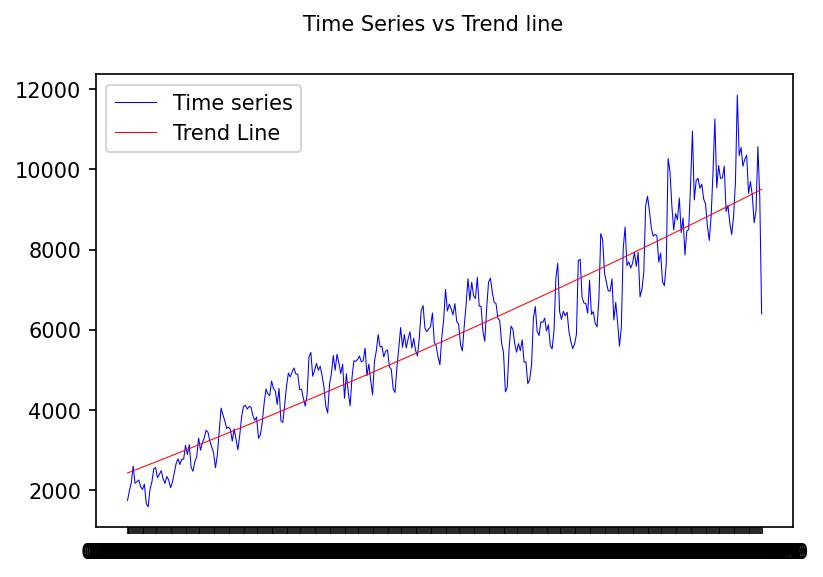

In [20]:
# plotting the trend line.
fig = plt.figure(dpi=150)
fig.suptitle('Time Series vs Trend line', fontsize=10)
plt.plot(df.iloc[:,0],df.iloc[:,1],label = "Time Series",color = 'b',linewidth = 0.5)
plt.plot(df.iloc[:,0],trend, label="Trend Line",color = 'r',linewidth = 0.5)
plt.legend(['Time series',"Trend Line"])
plt.show()

## Detrending the time series

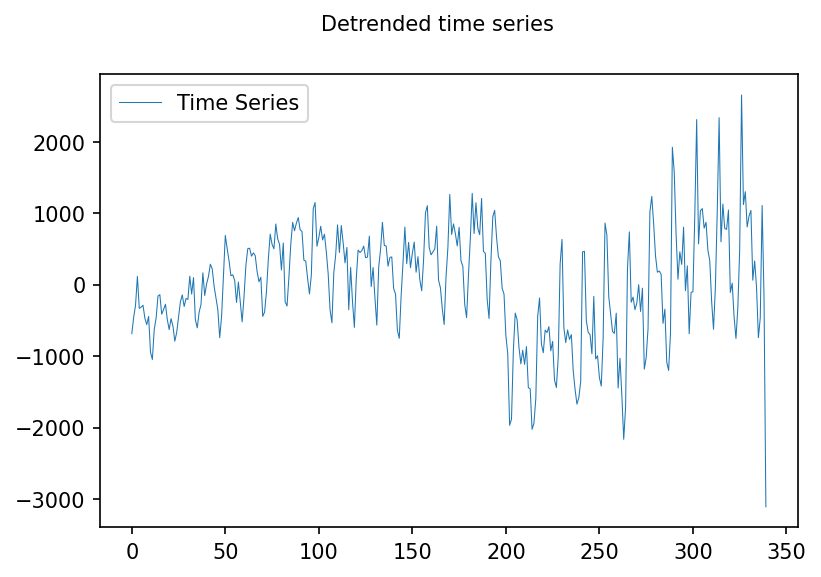

In [24]:
detrended = df['Price'] - trend
fig = plt.figure(dpi = 150)
fig.suptitle('Detrended time series', fontsize=10)
plt.plot(detrended,label = "Detrended Time Series",linewidth = 0.5)
plt.legend(["Time Series"])
plt.show()

## Seasonal components and creating final time series

In [22]:
# getting the seasonal component by taking the average of detrended series.
seasonal = detrended.groupby(by = df['Months']).mean()
print("Seasonal Components are:\n",seasonal)

Seasonal Components are:
 Months
01   -381.547335
02    453.838146
03    791.310836
04    155.870735
05    247.385377
06    202.990532
07    140.079446
08    278.187834
09   -257.184304
10   -160.608396
11   -672.655871
12   -834.076728
dtype: float64


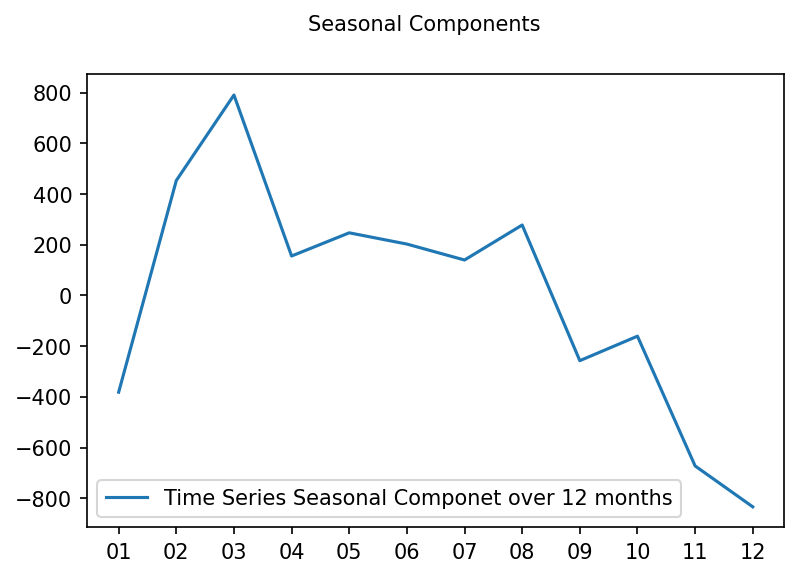

In [25]:
# Plotting the seasonal components
fig = plt.figure(dpi=150)
fig.suptitle('Seasonal Components', fontsize=10)
plt.plot(seasonal)
plt.legend(["Time Series Seasonal Componet over 12 months"])
plt.show()

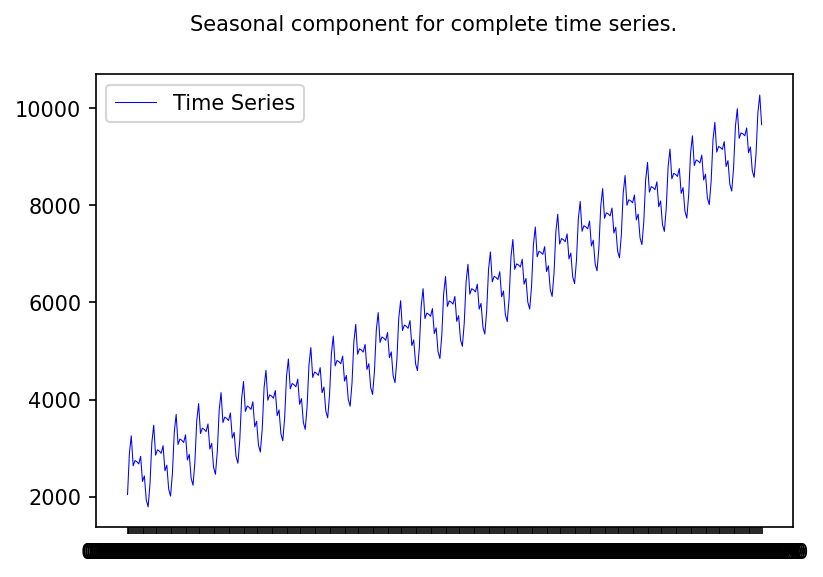

In [27]:
# creating a column for seasonal components and adding the trend values to it.
col = 'Total Price'
for i in seasonal.index:
    df.loc[df['Months'] == i, col] = seasonal.loc[i]
df[col] = df[col] + trend
fig = plt.figure(dpi=150)
fig.suptitle('Seasonal component for complete time series.', fontsize=10)
plt.plot(df['Date'],df['Total Price'],color='b',linewidth = 0.5)
plt.legend(["Time Series"])
plt.show()

# Class for Holt Winters Exponential Smoothening

In [12]:
# defining the class
class Holt_Winters:
    '''
    arguments:
    alpha, beta, gamma and seasons initially set to 0.5,0.5,0.5,12
    since by above decomposition the values of season is 12
    '''
    def __init__(self, season=24, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season = season

    # defining the fit function
    def fit_data(self, data):
        # getting values of parameters and data
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season = self.season
        seasonals = self.initial_seasonal(data)
        # initial values and trend
        p = []
        s = data[0]
        t = self.initial_trend(data)
        p.append(s)
        # fitting the data values and predicting the values of smoothness,trend, and seasonality 
        for i in range(1, len(data)):
            v = data[i]
            ps = s
            seasonal = seasonals[i % season]
            s = alpha * (v - seasonal) + (1 - alpha) * (ps + t)
            t = beta * (s - ps) + (1 - beta) * t
            seasonals[i % season] = gamma * (v - s) + (1 - gamma) * seasonal
            p.append(s + t + seasonals[i % season])
        # setting the values of fitted trend, smooth and seasonality
        self.trend_ = t
        self.smooth_ = s
        self.seasonals_ = seasonals
        self.predictions_ = p
        return self
    
    # function to get initial trend
    def initial_trend(self, data):
        season = self.season
        total = 0.0
        for i in range(season):
            total += (data[i + season] - data[i]) / season
        trend = total / season
        return trend

    # function to get initial season
    def initial_seasonal(self, data):
        season = self.season
        n_seasons = len(data) // season
        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season * j
            end_index = start_index + season
            season_average = np.sum(data[start_index:end_index]) / season
            season_averages[j] = season_average
        seasonals = np.zeros(season)
        seasons = np.arange(n_seasons)
        index = seasons * season
        for i in range(season):
            seasonal = np.sum(data[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal
        return seasonals

    # function for predicting the values of future data default predictions is 10
    def predict_data(self, n_preds=10):
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season]
            predictions.append(prediction)
        return predictions

In [13]:
# for fitting the time series the cross validation method is used.
def cross_val_score(params, series, loss_function, season_len=12, n_splits=3):
    errors = []    
    # getiing values of initial alpha beta and gamma
    # data is split into 3 folds
    alpha, beta, gamma = params
    print("For Alpha = ",alpha,' Beta = ',beta,' and Gamma = ',gamma)
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 
    print("Splitting the time series:",time_series_split)
    for train, test in time_series_split.split(series):
        print("Training data:\n",train)
        print("Testing data:\n",test)
        model = Holt_Winters(season_len, alpha, beta, gamma)
        model.fit_data(series[train])
        # predictions on the test set
        predictions = model.predict_data(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)
    return np.mean(errors)

# function for getting mean error for testing and predictions 
def mean_absolute_percentage_error(test,predict):
  return ((test-predict)/test).mean() * 100

In [32]:
# getting the data values
i = int(input("What would you like to see seasonal component or data component...1/2\n"))
if i == 1:
  data = df['Total Price']
elif i == 2:
   data = df['Price']
else:
  print("Wrong Choice")
print(data)
# seasonlaity peroid 
s_peroid = 12
#model = HoltWinters()
#model._initial_trend(data)
#model._initial_seasonal(data)

What would you like to see seasonal component or data component...1/2
2
0       1744
1       1990
2       2177
3       2601
4       2171
       ...  
335     8669
336     8971
337    10567
338     9314
339     6395
Name: Price, Length: 340, dtype: int64


In [33]:
# providing the values to initial alpha beta and gamma
x = [0, 0, 0]
# splitting the values for training and testing
test_size = 200
train = data.values[:test_size]
test = data.values[test_size:]
print(len(train))
# optimising the values of aplha beta and gamma using scipy.optimise function in which
# cross validation function is used 
# bounds are used to bound the values of alpha beta and gamma
# mean squared error is used for optimization
opt = minimize(cross_val_score, x0 = x, args=(train, mean_squared_error,s_peroid,3), method='TNC', bounds=((0, 1), (0, 1), (0, 1)))
print('original parameters: {}'.format(str(x)))
print('best parameters: {}'.format(str(opt.x)))

Streaming output truncated to the last 5000 lines.
For Alpha =  0.019062358457392126  Beta =  0.004920156546415094  and Gamma =  0.3487517811598141
Splitting the time series: TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
Training data:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Testing data:
 [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Training data:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Testing data:
 [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118

In [34]:
# getting the value of optimised alpha beta and gamma and testing the data 
alpha_final, beta_final, gamma_final = opt.x
model = Holt_Winters(12,alpha_final, beta_final, gamma_final)
model.fit_data(train)
predictions = model.predict_data(n_preds=len(test))

#print(test)
#print(predictions[test_size:])
print('Train series length: ', len(train))
print('Test series length: ', len(test))
print('prediction length: ', len(predictions))

Train series length:  200
Test series length:  140
prediction length:  340


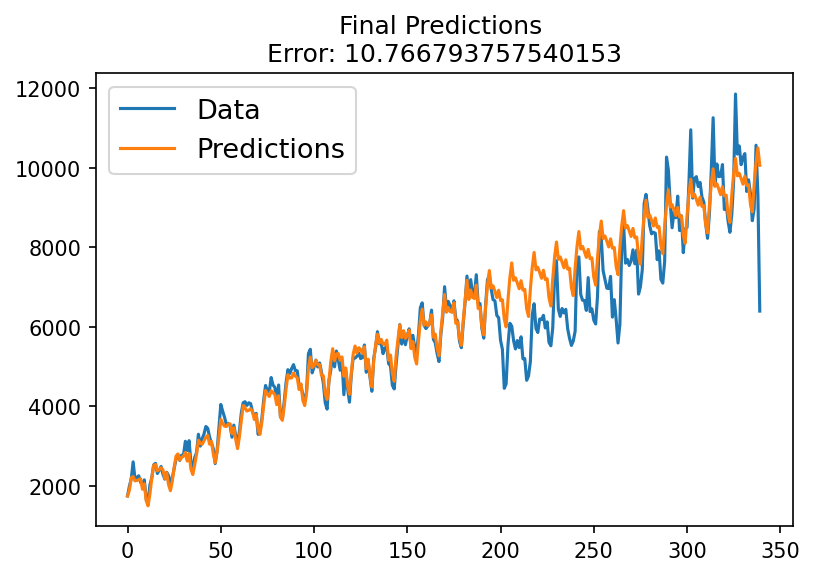

In [35]:
# getting the error and plotting the result.
error = mean_absolute_percentage_error(test, predictions[test_size:])
s = 'Final Predictions \nError: '+str(abs(error))
fig = plt.figure(dpi = 150)
plt.title(s)
plt.plot(data.values, label='Data')
plt.plot(predictions,label = 'Predictions')
plt.axvspan(len(data) - test_size, len(predictions), alpha=0.3, color='white')
plt.axis('tight')
plt.legend(loc='best', fontsize=13)
plt.show()